<a href="https://colab.research.google.com/github/pintu1803/DL/blob/main/fake_news_detection_3_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection Using Hybrid CNN-RNN model.
Team project:
1. Pintu (181CO139) 
2. Akshay Dhayal (181CO105)

In the guidance of Dr. M Venkatesan (CSE Prof. @NITK)

Note: Run 1st and 2nd cell first, then comment them out and run all cells.

# Mount Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


Download the GloVe: Pretrained word embedding model. It is developed by Standford NLP group. It is faster to compute than Word2Vec. Use: Dimensionality reduction

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-03-26 10:07:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-26 10:07:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-26 10:07:34--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

# Load and split the data

In [ ]:
#23/03/2021
#Pintu 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd

dataset=pd.read_csv('/content/drive/MyDrive/fake-news/train.csv')

#remove the missing data.
dataset=dataset.dropna()

n=int(0.8 * len(dataset))
x=dataset['text'].values[:n]
y=dataset['label'].values[:n]

x_valid=dataset['text'].values[n:]
y_valid=dataset['label'].values[n:]

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=1000)

print(type(x), type(y)) 
print(type(x_valid), type(y_valid))
print(type(x_train), type(x_test))
print(type(y_train), type(y_test))
#those ending with .values are ndarray.
#train_test_split output has same type as of input.

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Build Vocabulary 

tokenizer is the object created, of Tokenizer class. 
num_words=50000, it means we want only 1st 50k words from entire vocabulary to be used.
->> tokenizer.fit_on_texts(x_train)
action: 1) it collects all words from training data and counts the frequency of each word in that corpus.
2) All words are arranged in descending order. ie. most occured word is placed at index=1, 0 is not used as index.
3) Indexes are assigned to all unique words, but out of them only 1st 50K will be used.
4) This is stored in dictionary=word_index

->> x_train = tokenizer.texts_to_sequences(x_train)
action: All texts are converted in sequence of integers. Means that the words of text are replaced by their index in the dictionary=word_index.

->> x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
action: since all the texts are not of same length.
this will make their length equal. if text is shorter than maxlen then it will add 0's at the end (=post padding). if text size > maxlen then it will take only 1st maxlen words.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer                    
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=150000)
tokenizer.fit_on_texts(x_train)

#number of unique words in dict.
print("Number of unique words in dictionary=",len(tokenizer.word_index))

x_train = tokenizer.texts_to_sequences(x_train)
x_valid = tokenizer.texts_to_sequences(x_valid)
x_test = tokenizer.texts_to_sequences(x_test)

# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1  

#size of random text in training set.
print("Length of random text=",len(x_train[3]),len(x_train[13]))

maxlen = 400

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_valid = pad_sequences(x_valid, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

Number of unique words in dictionary= 159687
Length of random text= 426 25


Confirm that text is converted into vector.

In [ ]:
print(type(x_train))
for row in x_train:
  print(row)
  break

<class 'numpy.ndarray'>
[  495   242    83   671  2459   841     6     5  2038   331    40     1
  6059  1739     2  2500     1  7608     3   406  1579  2070     2 20028
   141   537   405    69 14944 37722     4  1811     3   202   422     9
   209 34808  8732    17   107     8     1  3364     1  6664     8  6891
     1  2307    51    21     9    87  8733     1  2414     3  6892     4
  1538   310    20 17403  3283    11    27   217     4    37  3035     8
 19410    27     8   293  7608     3   406  1579     4     1  2439  4105
    32  4297     2   325    21   268     2   138    40    27   916     3
  3263   367    59   121     2   209    27  1424     8   667     4  8960
     1  2307    21    30  5743  1693     2   276     7   100  1558   145
    19   208    55    31   137    31    20  1997     3 10192     4 22922
   640   109   205    57     3     5  2086  2364  5198   779     3 14653
  1076   388   105   479   295   198  3152  1461    21    47  1036     6
    53  2201     1    94  4

# Unzip the zip folder of GloVe

We have already downloaded and unzip the file, in previour run. 

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


# Create embedding matrix using GloVe

Each word of GloVe file is searched in vocabulary=word_index.
If word is found then, its index is fetched from vocabulary. Say index = ii
The dense vector of that word from GloVe file is taken and put at same index=ii
in embedding_matrix.
SO, in total we are doing 6B * vocab_size comparasions.

embedding_dim=100, it defines the length/size of dense vector.

If we take embedding_dim=100, then model will take longer training time.

In [ ]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
  
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 100
embedding_matrix = create_embedding_matrix('/content/glove.6B.100d.txt',
                                            tokenizer.word_index,  
                                            embedding_dim)

# Build Hybrid CNN-RNN model

1. The first layer of the neural network is the Keras embedding layer. This is the input layer through which the pre-trained word embeddings are utilized by providing the prepared embedding matrix and the model is trained by feeding in the training data

2. The next layer is the one-dimensional CNN layer (Conv1D) for extraction of local features by using 128 filters of size 5. The default Rectified Linear Unit (ReLU) activation function is used.

3. After that, the large feature vectors generated by CNN are pooled by feeding them in to a MaxPooling1D layer with a window size of 2, in order to down-sample the feature vectors, reduce the amount of parameters, and consequently the computations without affecting the network’s efficiency.

4. The pooled feature maps are fed into the RNN (LSTM) layer that follows. This input is used to train the LSTM, which outputs the long-term dependent features of the input feature maps, while retaining a memory. The dimension of the output is set to 32. The default linear activation function (i.e. ) of Keras is used in this layer.

5. Finally, the trained feature vectors are classified using a Dense layer that shrinks the output space dimension to 1, which corresponds to the classification label (i.e. fake or not fake). This layer applies the Sigmoid activation function.

The model is trained using the adaptive moment estimation (Adam) optimizer to define the learning rate in each iteration, the binary cross-entropy as the loss function, and the accuracy for the evaluation of results. The training is performed for 10 epochs using a batch size of 64.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 1st RUN with embedding_dim=100 & batch_size=64

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_valid, y_valid),
                    batch_size=64)
model.summary()

Epoch 1/10
86/86 [==============================] - 84s 943ms/step - loss: 0.5956 - accuracy: 0.6657 - val_loss: 0.4387 - val_accuracy: 0.7930
Epoch 2/10
86/86 [==============================] - 81s 946ms/step - loss: 0.4123 - accuracy: 0.8186 - val_loss: 0.3287 - val_accuracy: 0.8731
Epoch 3/10
86/86 [==============================] - 81s 937ms/step - loss: 0.3133 - accuracy: 0.8688 - val_loss: 0.3863 - val_accuracy: 0.8007
Epoch 4/10
86/86 [==============================] - 80s 931ms/step - loss: 0.2252 - accuracy: 0.9104 - val_loss: 0.2777 - val_accuracy: 0.8857
Epoch 5/10
86/86 [==============================] - 80s 928ms/step - loss: 0.3232 - accuracy: 0.8800 - val_loss: 0.2391 - val_accuracy: 0.9150
Epoch 6/10
86/86 [==============================] - 80s 925ms/step - loss: 0.1614 - accuracy: 0.9532 - val_loss: 0.1993 - val_accuracy: 0.9297
Epoch 7/10
86/86 [==============================] - 79s 921ms/step - loss: 0.1023 - accuracy: 0.9713 - val_loss: 0.1852 - val_accuracy: 0.9297

# Analysing the model performance.
Prediction, Accuracy, Confusion_matrix and Classification_report


In [ ]:
from math import floor
from sklearn.metrics import classification_report, confusion_matrix
def performance(x_test, y_test):
  y_pred=model.predict(x_test)
  # print(y_pred[0])
  y_pred=[1 if x>=0.5 else 0 for x in y_pred]
  # print(y_pred[0])
  cm=confusion_matrix(y_test, y_pred)
  cr=classification_report(y_test, y_pred)

  print("Confusion matrix=\n",cm)
  print("Classification report=\n",cr)

  loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
  print("Testing Accuracy: {:.2f}%".format(accuracy*100))#actual accuracy
  print("Testing Loss: {:.2f}%".format(loss*100)) #testing loss

#call the performance measure function
performance(x_test, y_test)


Confusion matrix=
 [[1931   93]
 [ 119 1514]]
Classification report=
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      2024
           1       0.94      0.93      0.93      1633

    accuracy                           0.94      3657
   macro avg       0.94      0.94      0.94      3657
weighted avg       0.94      0.94      0.94      3657

Testing Accuracy: 94.20%
Testing Loss: 19.24%


It took approx. 800 seconds or 14 minutes to run the 10 epochs.

Note that if you rerun the .fit() method, you’ll start off with the computed weights from the previous training. Make sure to call clear_session() before you start training the model again:

In [ ]:
# from keras.backend import clear_session
# clear_session()

Visualize the loss and accuracy for the training and testing data based on the History callback.

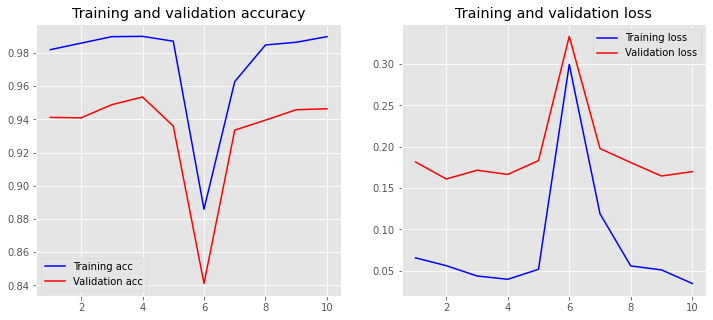

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


#call the function using history
plot_history(history)

WE can see that we have trained our model for too long since the training set reached 100% accuracy. A good way to see when the model starts overfitting is when the loss of the validation data starts rising again. This tends to be a good point to stop the model. You can see this around 20-40 epochs in this training.

Note: When training neural networks, you should use a separate testing and validation set. What you would usually do is take the model with the highest validation accuracy and then test the model with the testing set.

# 2nd RUN with embedding_dim=100 & batch_size=128

Epoch 1/10
86/86 [==============================] - 82s 958ms/step - loss: 0.0285 - accuracy: 0.9912 - val_loss: 0.1693 - val_accuracy: 0.9549
Epoch 2/10
86/86 [==============================] - 81s 938ms/step - loss: 0.7403 - accuracy: 0.7401 - val_loss: 0.4147 - val_accuracy: 0.8162
Epoch 3/10
86/86 [==============================] - 81s 942ms/step - loss: 0.2895 - accuracy: 0.8940 - val_loss: 0.2905 - val_accuracy: 0.8887
Epoch 4/10
86/86 [==============================] - 80s 934ms/step - loss: 0.1157 - accuracy: 0.9751 - val_loss: 0.2415 - val_accuracy: 0.9089
Epoch 5/10
86/86 [==============================] - 81s 948ms/step - loss: 0.0653 - accuracy: 0.9871 - val_loss: 0.1773 - val_accuracy: 0.9396
Epoch 6/10
86/86 [==============================] - 80s 935ms/step - loss: 0.0464 - accuracy: 0.9930 - val_loss: 0.1767 - val_accuracy: 0.9418
Epoch 7/10
86/86 [==============================] - 80s 936ms/step - loss: 0.0306 - accuracy: 0.9964 - val_loss: 0.1872 - val_accuracy: 0.9377

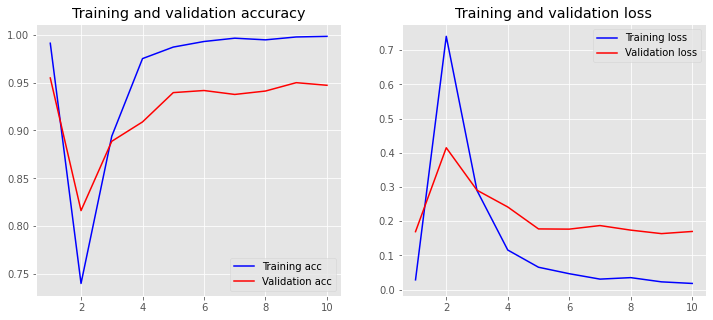

In [30]:
from keras.backend import clear_session
clear_session()

history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_valid, y_valid),
                    batch_size=128)
#compute performance
performance(x_test, y_test)

#call the function using history
plot_history(history)

# 3rd RUN & new model with embedding_dim=50, batch_size=64

Epoch 1/10
172/172 [==============================] - 76s 430ms/step - loss: 0.5636 - accuracy: 0.6911 - val_loss: 0.3553 - val_accuracy: 0.8551
Epoch 2/10
172/172 [==============================] - 73s 423ms/step - loss: 0.3131 - accuracy: 0.8699 - val_loss: 0.6071 - val_accuracy: 0.7673
Epoch 3/10
172/172 [==============================] - 78s 452ms/step - loss: 0.4227 - accuracy: 0.8239 - val_loss: 0.2808 - val_accuracy: 0.8903
Epoch 4/10
172/172 [==============================] - 72s 417ms/step - loss: 0.1977 - accuracy: 0.9313 - val_loss: 0.2546 - val_accuracy: 0.8986
Epoch 5/10
172/172 [==============================] - 71s 413ms/step - loss: 0.1771 - accuracy: 0.9365 - val_loss: 0.2620 - val_accuracy: 0.9043
Epoch 6/10
172/172 [==============================] - 71s 412ms/step - loss: 0.1600 - accuracy: 0.9485 - val_loss: 0.2375 - val_accuracy: 0.9125
Epoch 7/10
172/172 [==============================] - 71s 411ms/step - loss: 0.1204 - accuracy: 0.9589 - val_loss: 0.2431 - val_ac

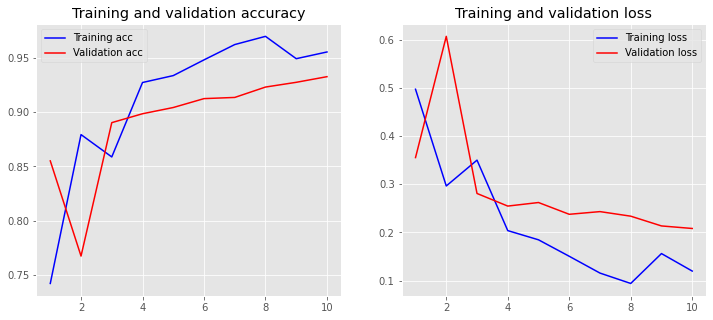

In [31]:
clear_session()

embedding_dim = 50
#build embedding matrix.
embedding_matrix = create_embedding_matrix('/content/glove.6B.50d.txt',
                                            tokenizer.word_index,  
                                            embedding_dim)

#buidl the hybrid cnn-rnn model.
model_1 = Sequential()
model_1.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model_1.add(layers.Conv1D(128, 5, activation='relu'))
model_1.add(layers.MaxPooling1D(2))
model_1.add(layers.LSTM(32))
model_1.add(layers.Dense(1, activation='sigmoid'))
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#train the model.
history_1 = model_1.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_valid, y_valid),
                    batch_size=64)

#confusion matrix and classification report.
performance(x_test, y_test)

#call the function using history
plot_history(history_1)

######################__A MODEL CREATED BY PINTU (181CO139) AND AKSHAY DHAYAL (181CO105) __####################